In [122]:
import json
import os
import glob 
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from datetime import time
from dateutil import parser as dt_parser 
import argparse
import time as timer
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import warnings

os.chdir('/mnt/home/mhacohen/python_files/')
from dreem_function_share import summary_data_dreem
from empatica_function_share import summary_data_empatica
from withings_function_share import summary_data_withings


In [2]:
share_dir = '/mnt/ceph/users/info/datasets/sleep_data/final_dr/'
SP_subs = [file for file in os.listdir(share_dir) if file.startswith('SP')]



In [3]:
df_dreem = pd.DataFrame()

for subject in SP_subs:
    try:
        df = summary_data_dreem(subject,share_dir)
        df_dreem = pd.concat([df_dreem,df])
        
    except Exception as e:
        print(f'{e} for subject: {subject}')


In [4]:
df_embrace = pd.DataFrame()

for subject in SP_subs:
    try:
        df = summary_data_empatica(subject,share_dir)
        df_embrace = pd.concat([df_embrace,df])
    except Exception as e:
        print(f'{e} for subject: {subject}')

[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0238810/empatica/summarized_data/' for subject: SP0238810
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0410385/empatica/summarized_data/' for subject: SP0410385
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0409495/empatica/summarized_data/' for subject: SP0409495
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0382387/empatica/summarized_data/' for subject: SP0382387
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0387013/empatica/summarized_data/' for subject: SP0387013
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0211300/empatica/summarized_data/' for subject: SP0211300


In [67]:
df_withinigs = pd.DataFrame()

for subject in SP_subs:
    try:
        df = summary_data_withings(subject,share_dir)
        df_withinigs = pd.concat([df_withinigs,df])
    except Exception as e:
        print(f'{e} for subject: {subject}')

[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0387013/withings/' for subject: SP0387013
[Errno 2] No such file or directory: '/mnt/ceph/users/info/datasets/sleep_data/final_dr/SP0217399/withings/' for subject: SP0217399


# Venn diagram of all nights

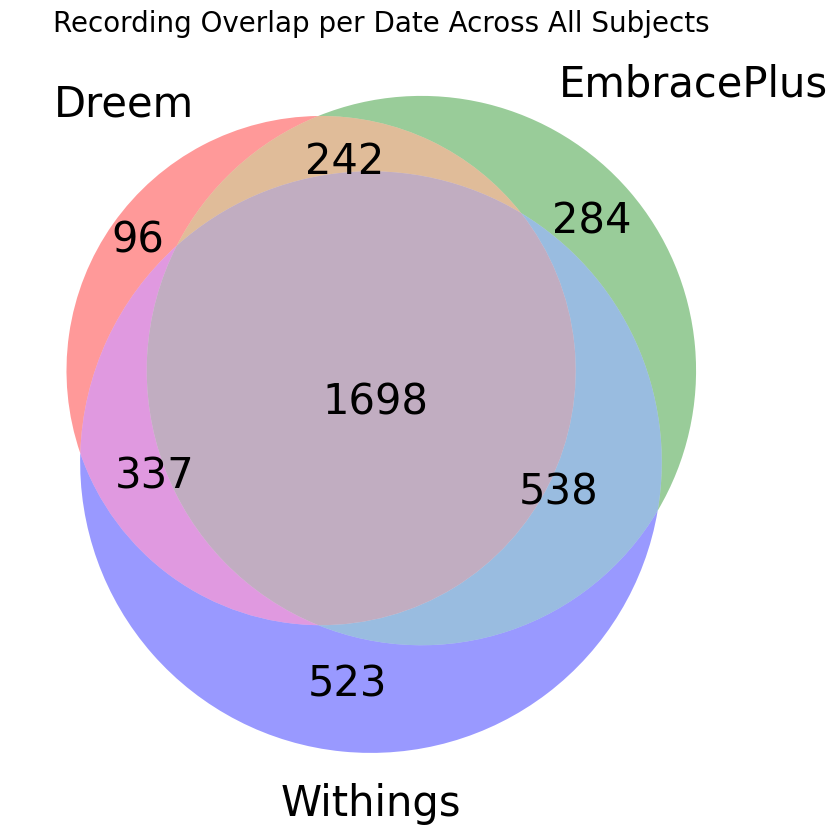

In [75]:

dreem_dates = df_dreem.drop_duplicates(['subject','date']).groupby('subject')['date'].apply(lambda x: pd.to_datetime(x).dt.date.unique()).to_dict()
emp_dates = df_embrace.drop_duplicates(['subject','date']).groupby('subject')['date'].apply(lambda x: pd.to_datetime(x).dt.date.unique()).to_dict()
with_dates = df_withinigs.drop_duplicates(['subject','date']).groupby('subject')['date'].apply(lambda x: pd.to_datetime(x).dt.date.unique()).to_dict()

def dates_to_tuples(date_dict):
    return [(subject, list(dates)) for subject, dates in date_dict.items()]

dreem_dates = dates_to_tuples(dreem_dates)
emp_dates = dates_to_tuples(emp_dates)
with_dates = dates_to_tuples(with_dates)

#emp_dates = np.load('/mnt/home/mhacohen/ceph/emp_dates.npy',allow_pickle=True)
emp_dates = {subject: set(dates) for subject, dates in emp_dates}

#dreem_dates = np.load('/mnt/home/mhacohen/ceph/dreem_dates.npy',allow_pickle=True)
dreem_dates = {subject: set(dates) for subject, dates in dreem_dates}

#with_dates = np.load('/mnt/home/mhacohen/ceph/with_dates.npy',allow_pickle=True)
with_dates = {subject: set(dates) for subject, dates in with_dates}
# Initialize a dictionary to hold the count of dates for each subject

subject_date_counts = {}

# Loop through each subject to find the intersection of dates
for subject in set(dreem_dates.keys()).union(with_dates.keys(), emp_dates.keys()):
    subject_dreem = dreem_dates.get(subject, set())
    subject_with = with_dates.get(subject, set())
    subject_emp = emp_dates.get(subject, set())

    # Calculate the intersection and update the counts
    subject_date_counts[subject] = {
        'dreem': len(subject_dreem),
        'empatica': len(subject_emp),
        'withings': len(subject_with),
        'dreem_emp': len(subject_dreem.intersection(subject_emp)),
        'dreem_with': len(subject_dreem.intersection(subject_with)),
        'emp_with': len(subject_emp.intersection(subject_with)),
        'all': len(subject_dreem.intersection(subject_emp, subject_with))
    }

# Now calculate the aggregate counts for each device and intersection
total_dreem = sum(count['dreem'] for count in subject_date_counts.values())
total_empatica = sum(count['empatica'] for count in subject_date_counts.values())
total_withings = sum(count['withings'] for count in subject_date_counts.values())

total_dreem_emp = sum(count['dreem_emp'] for count in subject_date_counts.values())
total_dreem_with = sum(count['dreem_with'] for count in subject_date_counts.values())
total_emp_with = sum(count['emp_with'] for count in subject_date_counts.values())

total_all = sum(count['all'] for count in subject_date_counts.values())

# Calculate the sizes for the Venn diagram
venn_sizes = (
    
    total_dreem - (total_dreem_with) - (total_dreem_emp ) + total_all,
    total_empatica - (total_dreem_emp) - (total_emp_with) + total_all,
    total_dreem_emp - total_all,
    total_withings - (total_dreem_with) - (total_emp_with) +  total_all,

    total_dreem_with - total_all,
    total_emp_with - total_all,
    total_all,
)

# Plotting the Venn diagram with corrected values
plt.figure(figsize=(10, 10))
venn = venn3(subsets=venn_sizes, set_labels=('Dreem', 'EmbracePlus', 'Withings'))
plt.title('Recording Overlap per Date Across All Subjects', fontsize=20)
# Increase the font size of the numbers inside the Venn diagram
for text in venn.subset_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(30)

for text in venn.set_labels:
    if text:  # Check if the label is not None
        text.set_fontsize(30)


# PLOT NIGHTS recorded per device 

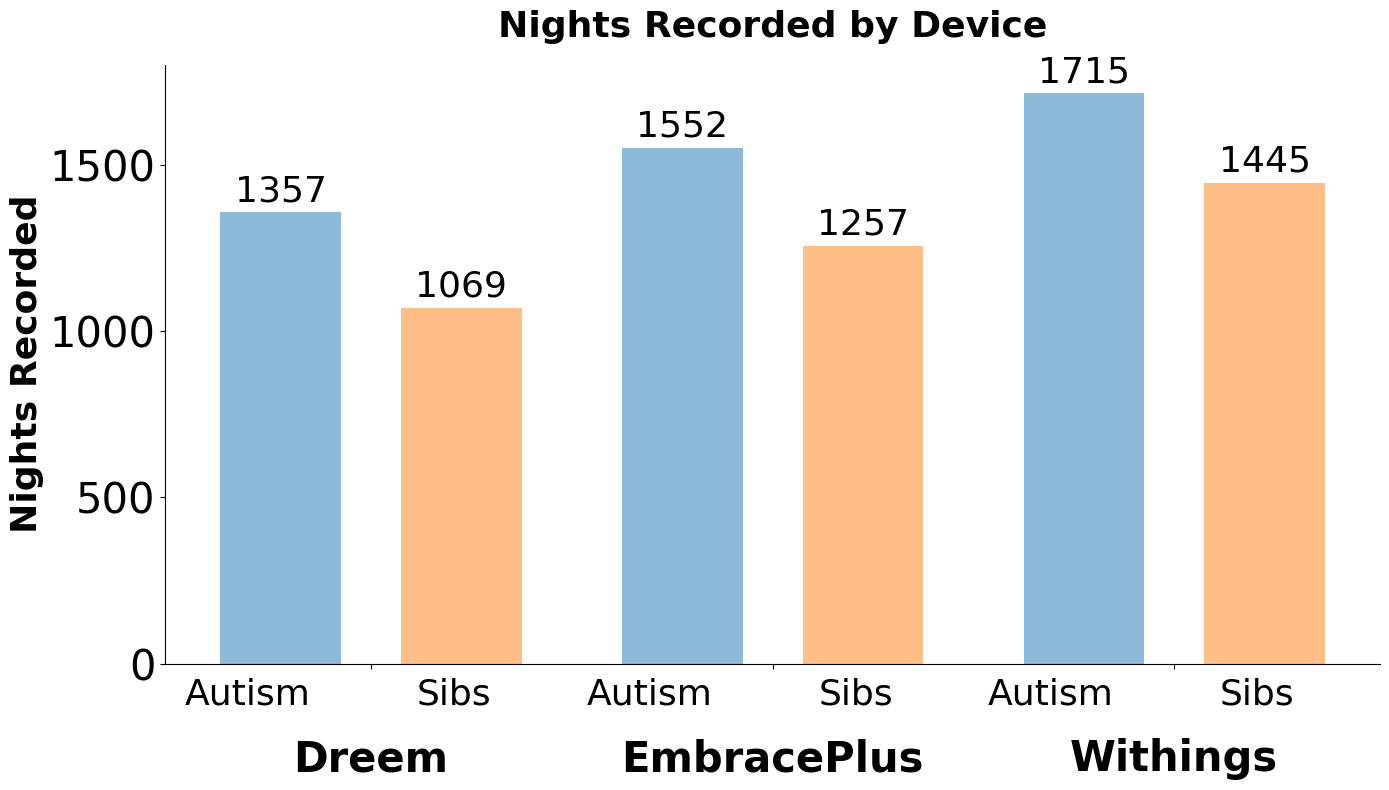

In [88]:

def plot_nights_recorded_with_annotations_and_gaps(df):
    devices = ['dreem', 'emp','with']
    device_labels = ['Dreem', 'EmbracePlus','Withings']
    user_types = ['ASD', 'Sibs']  # Changed to ASD and Sibs
    colors = ['C0', 'C1']  
    gap = 0.15  # Increased gap for better separation
    bar_width = 0.3  # Increased bar width
    
    # Data preparation
    data = {user_type: [] for user_type in user_types}
    for device in devices:
        for user_type in user_types:
            if device == 'dreem':
                nights = df[(df['user_type'] == user_type) & (df['TRT_dreem'].notna())].shape[0]
            elif device == 'with':
                nights = df[(df['user_type'] == user_type) & (df['TRT_withings'].notna())].shape[0]
            elif device == 'emp':
                nights = df[(df['user_type'] == user_type) & (df['TRT_empatica'].notna())].shape[0]
            data[user_type].append(nights)
    
    # Plotting with annotations and gaps
    X = np.arange(len(devices))
    fig, ax = plt.subplots(figsize=(14, 8))  # Increased figure size
    tick_positions = []
    
    for i, device in enumerate(devices):
        for j, user_type in enumerate(user_types):
            position = X[i] + (j * (bar_width + gap)) - gap/2
            bars = ax.bar(position, data[user_type][i], width=bar_width, color=colors[j], alpha=0.5)
            bar_labels = ax.bar_label(bars, label_type='edge', padding=3, fontsize=26)
            tick_positions.append(position)
    
    # Set x-ticks and labels
    ax.set_xticks(X + bar_width/2)
    ax.set_xticklabels(device_labels, fontsize=26, fontweight='bold')
    ax.tick_params(axis='x', which='major', pad=50, labelsize=30)
  
    def format_func(value, tick_number):
        return f'{int(value):,}'
    
    ax.tick_params(axis='y', labelsize=30)


    
    # Add user type labels
    for i, device in enumerate(devices):
        mid_position = X[i]
        ax.text(mid_position, -0.08, 'Autism', ha='right', va='bottom', fontsize=26, transform=ax.get_xaxis_transform())
        ax.text(mid_position + bar_width + gap, -0.08, 'Sibs', ha='right', va='bottom', fontsize=26, transform=ax.get_xaxis_transform())
    
    ax.set_ylabel('Nights Recorded', fontsize=26, fontweight='bold')
    ax.set_title('Nights Recorded by Device', fontsize=26, fontweight='bold', pad=20)
    
    # Remove x-axis label as it's now redundant
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# create df of all nights
df_all = df_withinigs.merge(df_embrace.merge(df_dreem,on=['subject','date'],how='outer',suffixes=('','_dreem')),on=['subject','date'],how='outer',suffixes=('_withings','_empatica'))
df_all = df_all.merge(participant_data.rename(columns = {'subject_sp_id':'subject'}), on='subject',how='left')
df_all['user_type'] = df_all['asd'].apply(lambda x: 'ASD' if x else 'Sibs')

# get participent data

participant_data_path = '/mnt/ceph/users/info/datasets/sleep_data/final_dr/20241016_participant_data.csv'

participant_data = pd.read_csv(participant_data_path)

plot_nights_recorded_with_annotations_and_gaps(df_all)


## Demogrpaich data 

/tmp/ipykernel_3805846/3002020599.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asd_df['Asd Age'] = current_year - asd_df.registration_year + asd_df.age_at_registration_years
/tmp/ipykernel_3805846/3002020599.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sibs_df['Sibs Age'] = current_year -sibs_df.registration_year + sibs_df.age_at_registration_years
/tmp/ipykernel_3805846/3002020599.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

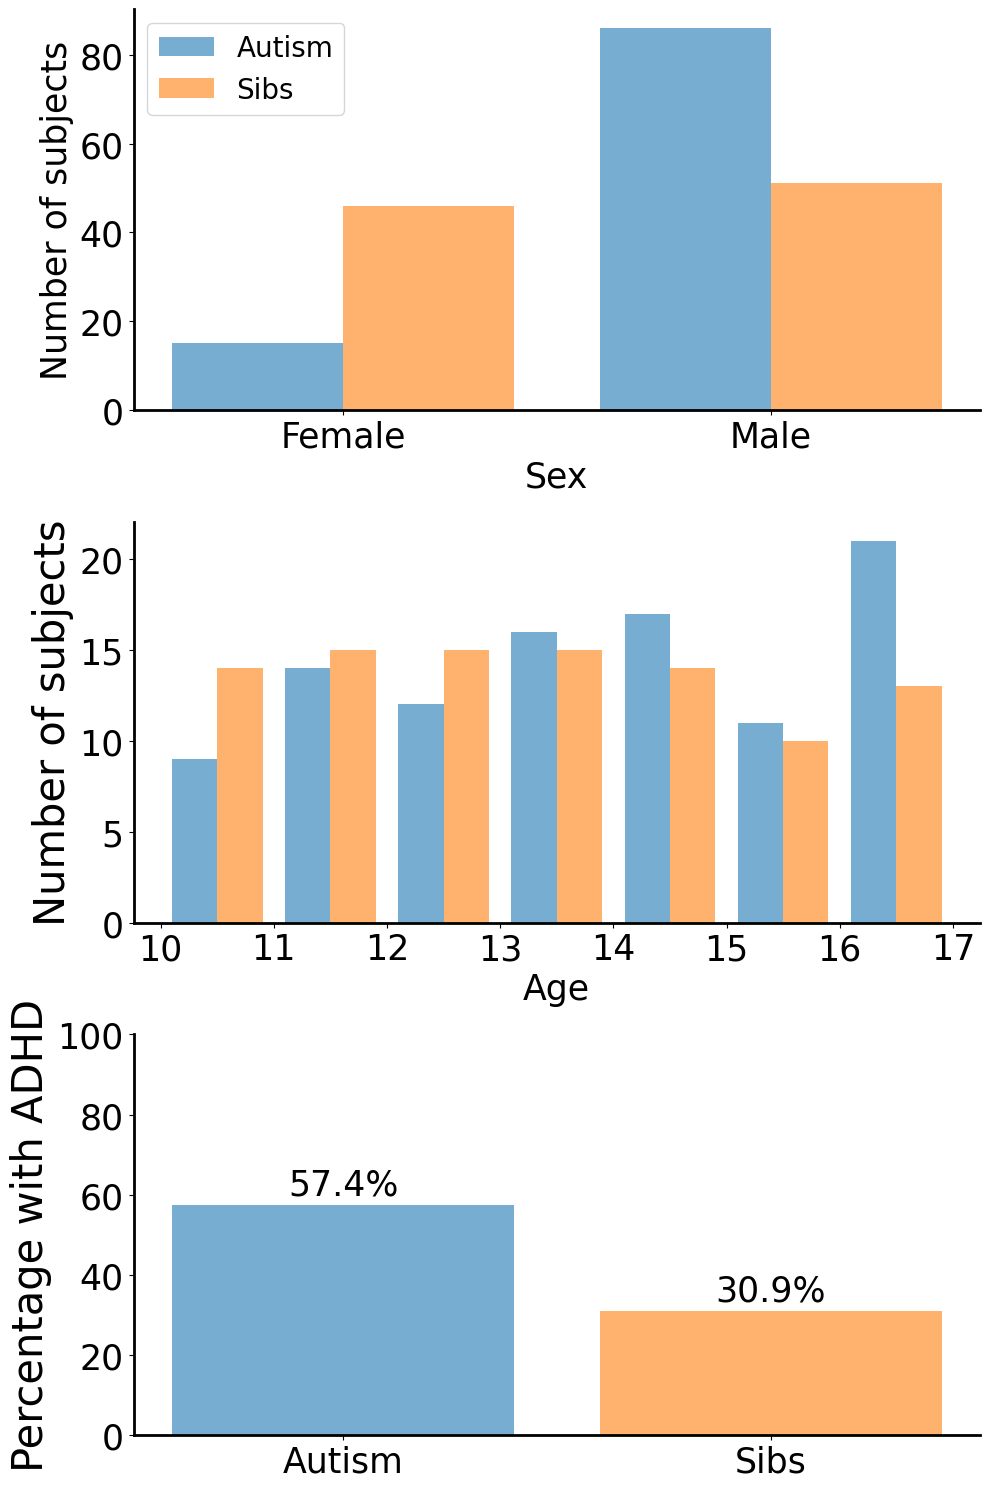

In [115]:
participant_data_path = '/mnt/ceph/users/info/datasets/sleep_data/final_dr/20241016_participant_data.csv'

participant_data = pd.read_csv(participant_data_path)
participant_data['user_type'] = participant_data['asd'].apply(lambda x: 'ASD' if x else 'Sibs')

medical_data_path = '/mnt/ceph/users/info/datasets/sleep_data/final_dr/20241016_999572_Medical Update Questionnaire.csv'
medical_data = pd.read_csv(medical_data_path)

participant_data = participant_data.merge(medical_data[['subject_sp_id','behavioral_disorders_adhd_add']],on='subject_sp_id',how='left')

participant_data.rename(columns= {'behavioral_disorders_adhd_add':'adhd'},inplace= True)

asd_df = participant_data[participant_data['asd']]
sibs_df = participant_data[~participant_data['asd']]

current_year = 2024

asd_df['Asd Age'] = current_year - asd_df.registration_year + asd_df.age_at_registration_years
# Extracting the year from DOB and calculating age for siblings (SIBS)
sibs_df['Sibs Age'] = current_year -sibs_df.registration_year + sibs_df.age_at_registration_years

# Make sure the 'Sex' columns are treated as categorical data

sex_categories = ['Female', 'Male']  # Keep this order for 0=Female, 1=Male

# Convert to categorical with the same categories for both DataFrames
asd_df['sex'] = pd.Categorical(asd_df['sex'], categories=sex_categories)
sibs_df['sex'] = pd.Categorical(sibs_df['sex'], categories=sex_categories)

asd_df['sex'] = asd_df['sex'].astype('category')
sibs_df['sex'] = sibs_df['sex'].astype('category')

sex_bins = [0, 1, 2]  
sex_labels = ['Female', 'Male']

# Define bins for the Age histogram (from 10 to 17)
age_bins = range(10, 18)

# Plotting histogram for Sex and Age
asd_adhd_percentage = (asd_df['adhd'] == 1).mean() * 100
sibs_adhd_percentage = (sibs_df['adhd'] == 1).mean() * 100

# Plotting histogram for Sex, Age, and ADHD percentage
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Histogram for ASD and SIBS Sex side by side
ax1.hist([asd_df['sex'].cat.codes, sibs_df['sex'].cat.codes], bins=sex_bins, color=['C0', 'C1'], label=['Autism', 'Sibs'], align='left', alpha=0.6)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(sex_labels, fontsize=16)
ax1.set_xlabel('Sex', fontsize=25)
ax1.set_ylabel('Number of subjects', fontsize=25)
ax1.legend(loc='upper left', fontsize=20) 
ax1.tick_params(axis='both', which='major', labelsize=25)

# Histogram for ASD and SIBS Age side by side
ax2.hist([asd_df['Asd Age'], sibs_df['Sibs Age']], bins=age_bins, color=['C0', 'C1'], label=['Autism', 'Sibs'], align='mid', alpha=0.6)
ax2.set_xlabel('Age', fontsize=25)
ax2.set_ylabel('Number of subjects', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=25)

ax3.bar(['Autism', 'Sibs'], [asd_adhd_percentage, sibs_adhd_percentage], color=['C0', 'C1'], alpha=0.6)
ax3.set_ylabel('Percentage with ADHD', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=25)
ax3.set_ylim(0, 100)  # Set y-axis limit from 0 to 100%

# Add percentage labels on top of the bars
for i, v in enumerate([asd_adhd_percentage, sibs_adhd_percentage]):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontsize=25)

# Adjust spines for all subplots
for ax in [ax1, ax2, ax3]:
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Make left and bottom spines thicker
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

# Adjust the layout and show the plot
plt.tight_layout()
plt.savefig('bar_data9.png', dpi=300, bbox_inches='tight')
plt.show()


In [120]:
asd_df['sex'].cat.codes
sibs_df['sex'].cat.codes

1      0
3      1
5      1
7      0
8      1
      ..
188    0
191    1
192    1
194    1
196    0
Length: 97, dtype: int8

In [ ]:
ax1.hist([asd_df['sex'].cat.codes, sibs_df['sex'].cat.codes], bins=sex_bins, color=['C0', 'C1'], label=['Autism', 'Sibs'], align='left', alpha=0.6)
